In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [49]:

df = pd.read_pickle('Project-3_NYC_311_Calls.pkl')


In [50]:

print(df.head())

   Unique Key        Created Date Agency  \
0    20184537 2011-04-06 00:00:00    HPD   
1    20184538 2011-04-06 00:00:00    HPD   
2    20184539 2011-04-06 00:00:00    HPD   
3    54732265 2022-07-08 11:14:43   DSNY   
4    20184540 2011-04-06 00:00:00    HPD   

                                         Agency Name        Complaint Type  \
0  Department of Housing Preservation and Develop...               HEATING   
1  Department of Housing Preservation and Develop...  GENERAL CONSTRUCTION   
2  Department of Housing Preservation and Develop...       PAINT - PLASTER   
3                           Department of Sanitation       Dirty Condition   
4  Department of Housing Preservation and Develop...              NONCONST   

  Descriptor         Location Type Incident Zip      City  \
0       HEAT  RESIDENTIAL BUILDING      10002.0  NEW YORK   
1    WINDOWS  RESIDENTIAL BUILDING      11236.0  BROOKLYN   
2      WALLS  RESIDENTIAL BUILDING      10460.0     BRONX   
3      Trash          

## EDA PART ##

#### make the index as a proper DatetimeIndex, and then delete the Created Date column ####


In [51]:
df['Created Date'] = pd.to_datetime(df['Created Date'])
df = df.set_index('Created Date')

In [52]:
# Get the general information about the DataFrame, including column data types and non-null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33780977 entries, 2011-04-06 00:00:00 to 2011-04-06 00:00:00
Data columns (total 11 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Unique Key              int64 
 1   Agency                  object
 2   Agency Name             object
 3   Complaint Type          object
 4   Descriptor              object
 5   Location Type           object
 6   Incident Zip            object
 7   City                    object
 8   Resolution Description  object
 9   Borough                 object
 10  Open Data Channel Type  object
dtypes: int64(1), object(10)
memory usage: 3.0+ GB
None


#### Count the unique complaint types and their frequency ####

In [53]:
complaint_counts = df['Complaint Type'].value_counts()
print(complaint_counts)

# Display the top 10 most frequent complaint types
print(complaint_counts.head(10))

Complaint Type
Noise - Residential               3131834
Illegal Parking                   2110646
HEAT/HOT WATER                    1983520
Blocked Driveway                  1439795
Street Condition                  1212154
                                   ...   
c:\windows\win.ini                      1
idexf3mrb7)(!(objectClass=*)            1
%E5%98%8A%E5%98%8DX-Injecti...          1
() { :;}; /bin/sleep 11                 1
Misc. Comments{${sleep(20)}}            1
Name: count, Length: 485, dtype: int64
Complaint Type
Noise - Residential                    3131834
Illegal Parking                        2110646
HEAT/HOT WATER                         1983520
Blocked Driveway                       1439795
Street Condition                       1212154
Street Light Condition                 1115391
Noise - Street/Sidewalk                1101122
Request Large Bulky Item Collection    1073753
PLUMBING                                890888
HEATING                                 887869

#### Earliest and latest dates in the dataset ####

In [54]:
earliest_date = df.index.min()
latest_date = df.index.max()
print(f"Earliest date: {earliest_date}")
print(f"Latest date: {latest_date}")

Earliest date: 2010-01-01 00:00:00
Latest date: 2023-08-04 12:00:00


#### Visualization of Complaints Over Time ####

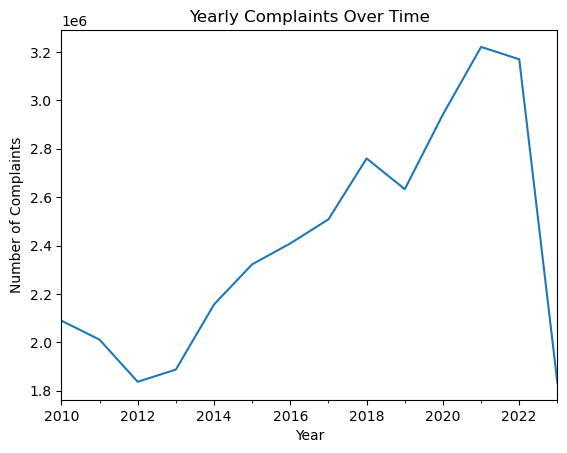

In [67]:
df['Complaint Type'].resample('Y').count().plot(title='Yearly Complaints Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Complaints')
plt.show()


#### Filter complaint types and plot its frequency over time ####

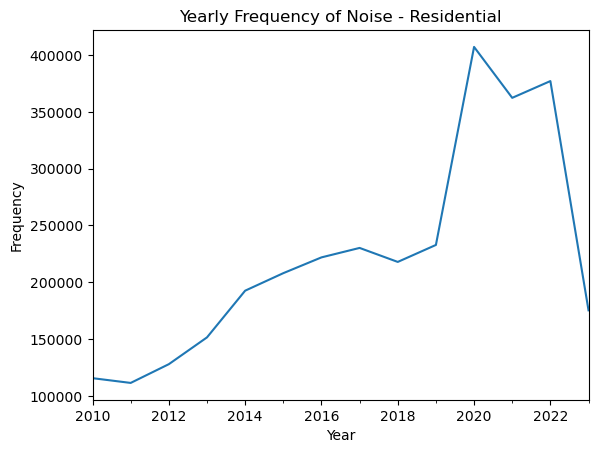

In [68]:
specific_complaint = 'Noise - Residential'
df[df['Complaint Type'] == specific_complaint]['Complaint Type'].resample('Y').count().plot(title=f'Yearly Frequency of {specific_complaint}')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


## the average number of daily complaints received in 2022 ##

In [57]:
# Sampling of data on a daily basis to calculate the number of complaints per day
daily_complaints = df['Unique Key'].resample('D').count()

# filter data in 2022
daily_complaints_2022 = daily_complaints['2022']

# Calculation of the average number of complaints per day in 2022
average_daily_complaints_2022 = daily_complaints_2022.mean()
average_daily_complaints_2022


8684.320547945206

## The date with the maximum number of calls ##

In [58]:
# Sampling of data on a daily basis to calculate the number of complaints per day
daily_complaints = df['Unique Key'].resample('D').count()

# find the date with the maximum number of calls
max_calls_date = daily_complaints.idxmax()

# print result 
print(f"The date with the maximum number of calls is: {max_calls_date}")


The date with the maximum number of calls is: 2020-08-04 00:00:00


## On the date the maximum number of calls were received, the most important complaint type ##

In [59]:
# date with the maximum number of calls is 2020-08-04 beased on previous question 
specific_date_df = df.loc['2020-08-04']

# find the complaint type
top_complaint_on_specific_date = specific_date_df['Complaint Type'].value_counts().idxmax()

print(f"On 2020-08-04, the most common complaint type was: {top_complaint_on_specific_date}")


On 2020-08-04, the most common complaint type was: Damaged Tree


## The quietest month historically ##


In [63]:
# group by monthly 
monthly_calls = df.groupby(df.index.month)['Unique Key'].count()

# count average call monthly 
monthly_average_calls = monthly_calls.groupby(monthly_calls.index).mean()

# quietest month 
quietest_month = monthly_average_calls.idxmin()

print(f"The quietest month historically, on average, is: Month {quietest_month}")


The quietest month historically, on average, is: Month 12


## Perform ETS decomposition based on an additive model.  What is the value of the seasonal component on 2020-12-25 ##


In [64]:
# Resample the series to a daily frequency
daily_series = df['Unique Key'].resample('D').count()

# Perform ETS decomposition based on an additive model
decomposition = seasonal_decompose(daily_series, model='additive')

# Extract the seasonal component
seasonal = decomposition.seasonal

# Find the value of the seasonal component on 2020-12-25
seasonal_value = seasonal['2020-12-25']

# Round the value to the nearest integer
rounded_seasonal_value = round(seasonal_value)

rounded_seasonal_value


183

## Calculate the autocorrelation of the number of daily calls with the number of calls the day prior ##

In [65]:
# Resample the series to a daily frequency
daily_calls = df['Unique Key'].resample('D').count()

# Calculate the autocorrelation with lag of 1.
autocorrelation_lag_1 = daily_calls.autocorr(lag=1)

autocorrelation_lag_1


0.7517059728398577

## Forecast the daily series with a test set of 90 days using the Prophet library. RMSE on test set ##

In [66]:
daily_calls = df['Unique Key'].resample('D').count().reset_index()
daily_calls.columns = ['ds', 'y']

# Split the dataset into training and testing sets
train = daily_calls[:-90]
test = daily_calls[-90:]

# Create and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train)

# Create a DataFrame for the prediction dates
future = model.make_future_dataframe(periods=90)

# Predict
forecast = model.predict(future)

# Calculate the RMSE
forecasted = forecast[-90:]['yhat']
actual = test['y']
rmse = sqrt(mean_squared_error(actual, forecasted))

rmse


18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing


1231.9040525595656